In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [88]:
df=pd.read_csv("./../data/prep_acetylcholinesterase_activity_data.csv")
df=df.iloc[:,1:]
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,label
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active


**Calculate Lipinski descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

Molecular weight < 500 Dalton

Octanol-water partition coefficient (LogP) < 5

Hydrogen bond donors < 5

Hydrogen bond acceptors < 10


In [89]:
#calculating descriptors
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [90]:
df_lip=lipinski(df["canonical_smiles"])
print(df_lip.shape)
df_lip.head()

(6157, 4)


,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0


In [91]:
#combining liplinski variables with original df
df_comb=pd.concat([df,df_lip], axis=1)
df_comb.head()

,molecule_chembl_id,canonical_smiles,standard_value,label,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0.0,6.0


In [92]:
#converting IC_50 data to pIC_50
#which is nothing but just taking  -log10(IC_50) for making those data more normally distributed

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [93]:
# Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [94]:
df_norm= norm_value(df_comb)
df_norm

/tmp/ipykernel_3124/4215111532.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


,molecule_chembl_id,canonical_smiles,label,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,750.000
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,100.000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,50000.000
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,300.000
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,800.000
...,...,...,...,...,...,...,...,...
6152,CHEMBL5219841,COc1cccc2c1CCCC2NS(=O)(=O)NC(=O)OCc1ccccc1,active,390.461,2.8334,2.0,5.0,0.209
6153,CHEMBL5219046,CC[C@@]1(c2cccc(OC(=O)Nc3ccccc3)c2)CCCCN(C)C1,active,352.478,5.0610,1.0,3.0,274.000
6154,CHEMBL5219594,O=c1[nH]c2ccc(OCc3ccc(F)cc3)cc2c(=O)o1,inactive,287.246,2.1994,1.0,4.0,76200.000
6155,CHEMBL5219958,CC(C)c1ccc(COc2ccc3[nH]c(=O)oc(=O)c3c2)cc1,inactive,311.337,3.1837,1.0,4.0,55000.000


In [95]:
df_norm["standard_value_norm"].describe()


count    6.157000e+03
mean     1.064665e+05
std      9.218081e+05
min      0.000000e+00
25%      1.480000e+02
50%      2.300000e+03
75%      1.700000e+04
max      4.960000e+07
Name: standard_value_norm, dtype: float64

In [96]:
df_prep=pIC50(df_norm)
df_prep.head()

/tmp/ipykernel_3124/2410917963.py:9: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))
/tmp/ipykernel_3124/2410917963.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,label,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910


In [97]:
df_prep["pIC50"].describe()

count    6157.000000
mean             inf
std              NaN
min         1.304518
25%         4.769551
50%         5.638272
75%         6.829738
max              inf
Name: pIC50, dtype: float64

In [98]:
# print(df_prep.shape)
# df_prep=df_prep[df_prep["label"]!="intermediate"]
# print(df_prep.shape)

In [103]:
df_prep[df_prep["label"]=="intermediate"]

,molecule_chembl_id,canonical_smiles,label,MW,LogP,NumHDonors,NumHAcceptors,pIC50
5,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,intermediate,338.436,4.07992,0.0,5.0,5.619789
16,CHEMBL131536,CSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N(C)c1ccccc1,intermediate,358.854,4.42490,0.0,5.0,5.853872
18,CHEMBL334971,CCSc1nc(-c2ccc(OC)cc2)nn1C(=O)N(C)c1ccccc1,intermediate,368.462,4.17020,0.0,6.0,5.958607
36,CHEMBL65667,CN1CC[C@@]2(C)c3cc(OC(=O)NCCCN4CCOCC4)ccc3N(C)...,intermediate,388.512,1.86640,1.0,6.0,5.420216
40,CHEMBL152722,COc1cc(N)c(Cl)cc1C(=O)NCCNCc1ccc(CN(C)C)o1,intermediate,380.876,2.10500,3.0,6.0,5.508638
...,...,...,...,...,...,...,...,...
6118,CHEMBL5186889,CCCCN(CCc1c[nH]c2c(OC(=O)C(C)C)cccc12)CCC1CCCCCC1,intermediate,426.645,6.73440,1.0,3.0,5.863914
6126,CHEMBL206642,CC(C)c1ccc(NC(=O)Oc2ccc3c(c2)[C@]2(C)CCO[C@@H]...,intermediate,353.418,4.81740,1.0,4.0,5.576754
6134,CHEMBL5220228,CCN(C)C(=O)Oc1cccc(CN2CCC(CCC(=O)c3cc(Cl)c(N)c...,intermediate,488.028,5.25640,1.0,6.0,5.381952
6145,CHEMBL1190983,C#CCN(C)C1CCc2c(OC(=O)N(C)CC)cccc21,intermediate,286.375,2.68940,0.0,3.0,5.397940


In [100]:
df_prep.to_csv("./../data/acetylcholinesterase_activity_prep2_data.csv")

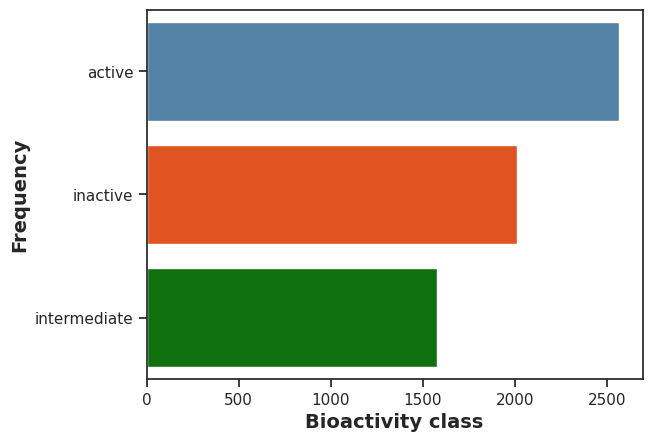

In [104]:
# countplot of distribution of activity labels
sns.countplot(y='label', data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
# Show the plot
plt.show()

/N/soft/rhel7/python/gnu/3.10.5/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/N/soft/rhel7/python/gnu/3.10.5/lib/python3.10/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


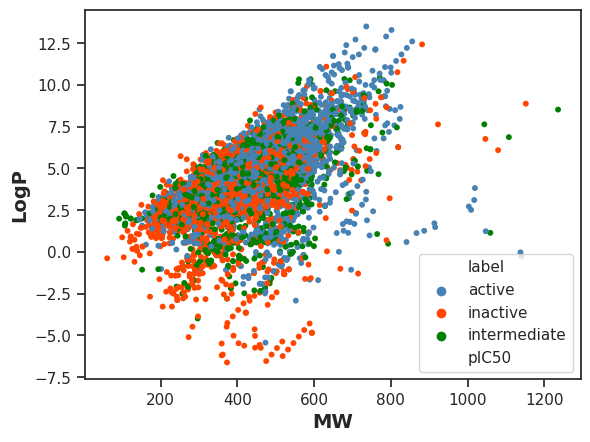

In [105]:
sns.scatterplot(x='MW', y='LogP',  hue="label",size="pIC50",data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

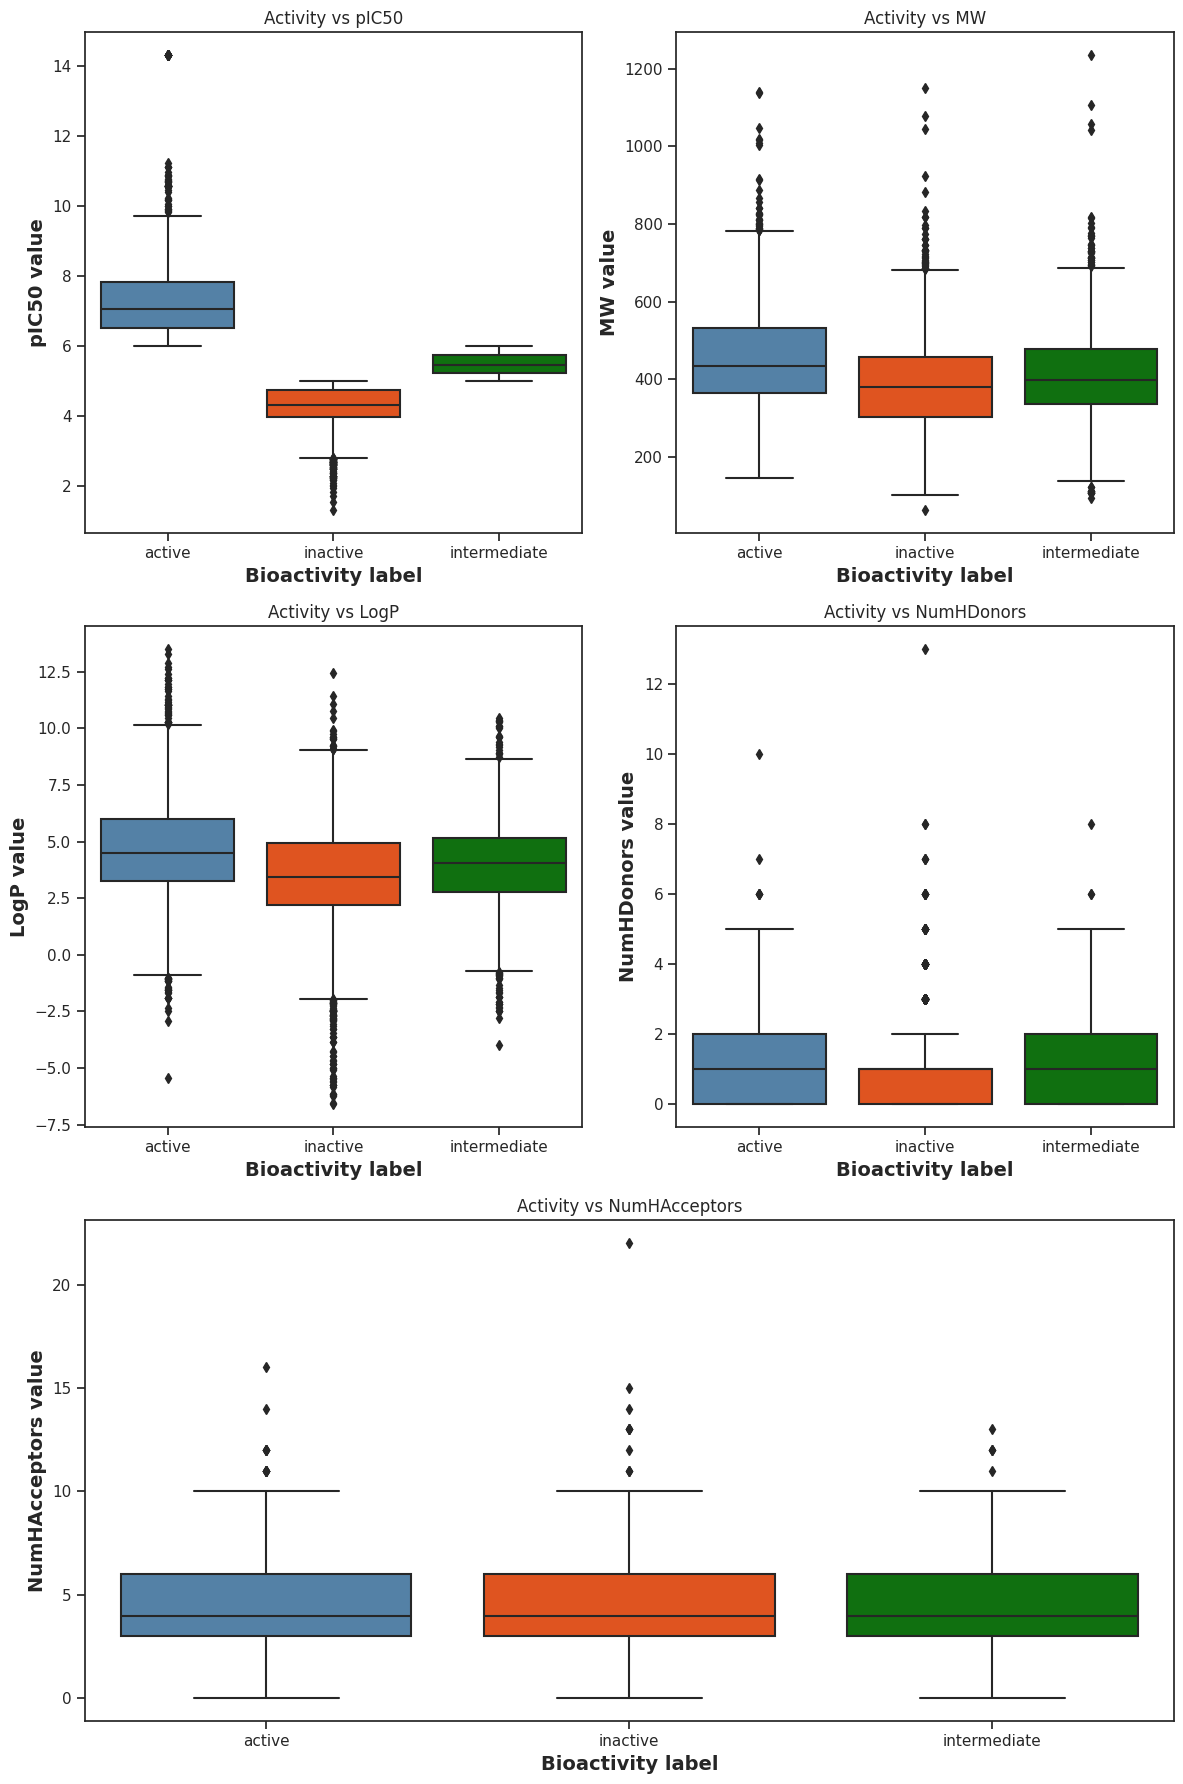

In [106]:

# Initialize the Matplotlib figure and create a 2x2 grid for the subplots
plt.figure(figsize=(12, 18))

# Flatten the axes array for easier indexing


# Create the boxplots
plt.subplot2grid((3, 2), (0, 0))
sns.boxplot(x='label', y='pIC50',  data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('Bioactivity label', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')
plt.title('Activity vs pIC50')

plt.subplot2grid((3, 2), (0, 1))
sns.boxplot(x='label', y='MW',  data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('Bioactivity label', fontsize=14, fontweight='bold')
plt.ylabel('MW value', fontsize=14, fontweight='bold')
plt.title('Activity vs MW')

plt.subplot2grid((3, 2), (1, 0))
sns.boxplot(x='label', y='LogP',  data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('Bioactivity label', fontsize=14, fontweight='bold')
plt.ylabel('LogP value', fontsize=14, fontweight='bold')
plt.title('Activity vs LogP')

plt.subplot2grid((3, 2), (1, 1))
sns.boxplot(x='label', y='NumHDonors',  data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('Bioactivity label', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors value', fontsize=14, fontweight='bold')
plt.title('Activity vs NumHDonors')

plt.subplot2grid((3, 2), (2, 0), colspan=2)
sns.boxplot(x='label', y='NumHAcceptors',  data=df_prep, palette={"active": "steelblue", "inactive": "orangered", "intermediate":"green"})
plt.xlabel('Bioactivity label', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors value', fontsize=14, fontweight='bold')
plt.title('Activity vs NumHAcceptors')

# Show the plot
plt.tight_layout()
plt.show()

**Hypothesis Testing**

In [107]:
# Statistical analysis
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'label']
  df = df_prep[selection]
  active = df[df.label == 'active']
  active = active[descriptor]

  selection = [descriptor, 'label']
  df = df_prep[selection]
  inactive = df[df.label == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [108]:

result=pd.concat([mannwhitney('pIC50'),mannwhitney('MW'), mannwhitney('LogP'),mannwhitney('NumHDonors'),mannwhitney('NumHAcceptors')])

# Reset the index
result.reset_index(drop=True, inplace=True)

result

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,5162792.0,0.000000e+00,0.05,Different distribution (reject H0)
1,MW,3331498.0,4.509937e-64,0.05,Different distribution (reject H0)
2,LogP,3335321.5,1.042594e-64,0.05,Different distribution (reject H0)
3,NumHDonors,2973512.5,1.998370e-20,0.05,Different distribution (reject H0)
4,NumHAcceptors,2790718.5,1.707218e-06,0.05,Different distribution (reject H0)


From our significance testing and boxplot, we can claim with 95% confidence that all of the four variables (MW, LogP, NumHDonors, NumHAcceptors) of Lipinski's descriptor plays as significant differentiator in the drug Likelihoodness of the compunds.